In [6]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error 

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [23]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [12]:
original = train.copy()

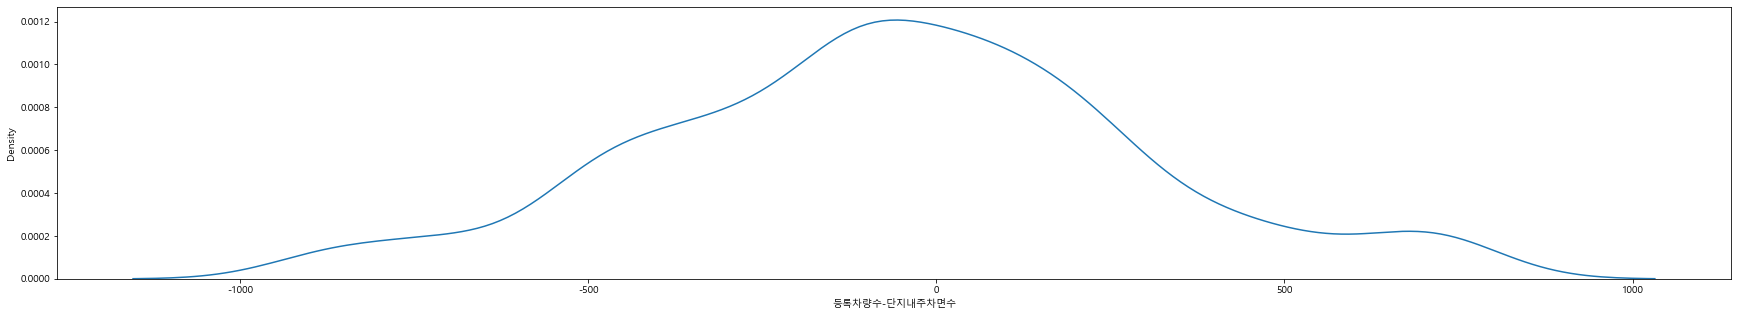

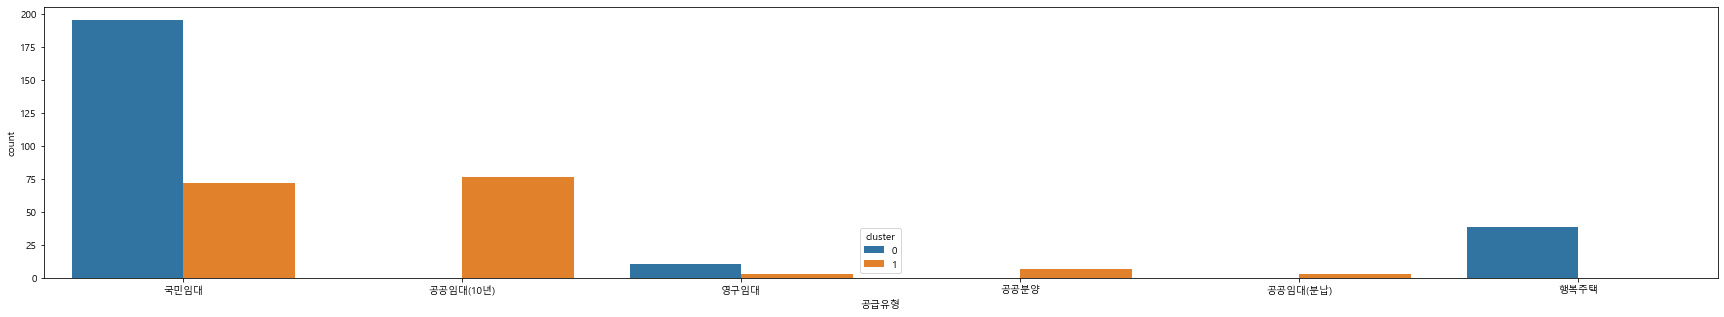

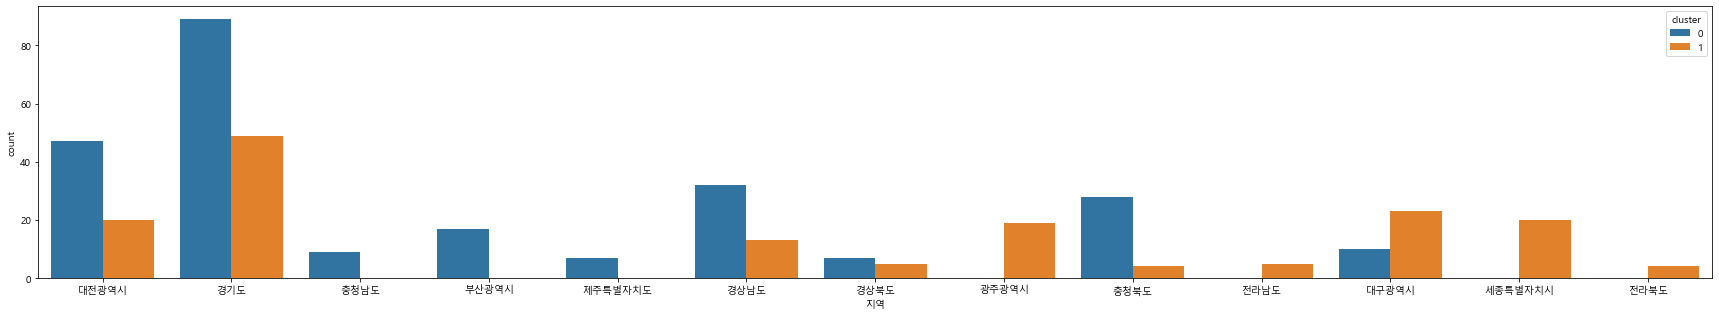

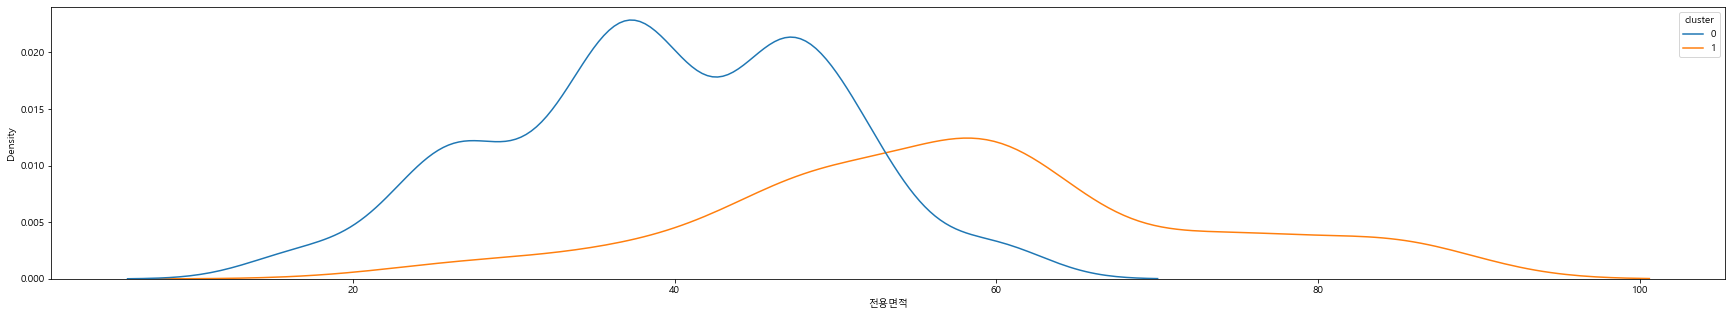

In [24]:
train = train[train['단지내주차면수']>=785].reset_index(drop=True)
test = test[test['단지내주차면수']>=785].reset_index(drop=True)

tmp=train.drop_duplicates(keep='first')
tmp['등록차량수-단지내주차면수'] = tmp.apply(lambda x : x['등록차량수']-x['단지내주차면수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-단지내주차면수']>0 else 0 ,axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-단지내주차면수')

tmp = tmp[(tmp['등록차량수-단지내주차면수']>200)|(tmp['등록차량수-단지내주차면수']<-200)]

tmp.columns

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='전용면적',hue='cluster')

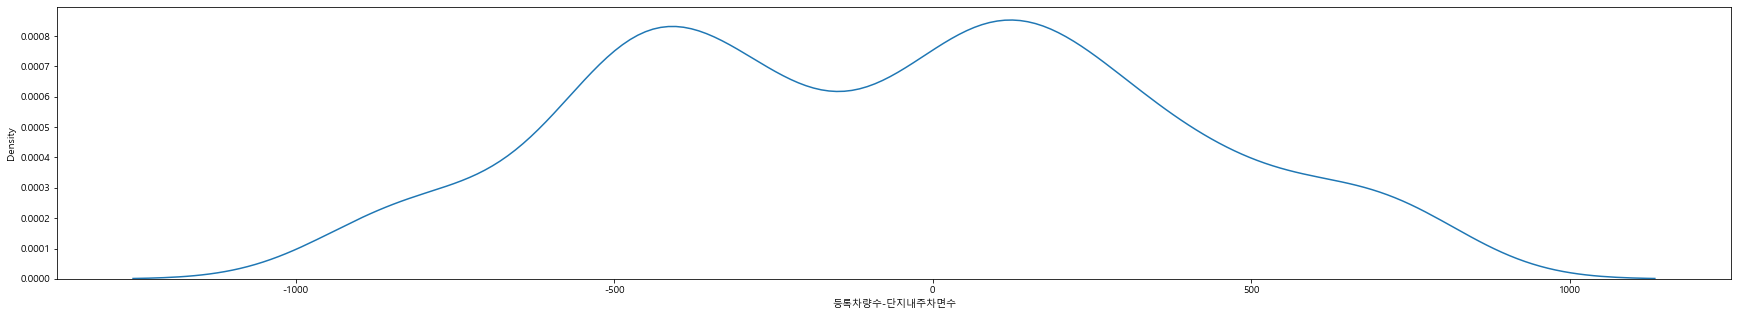

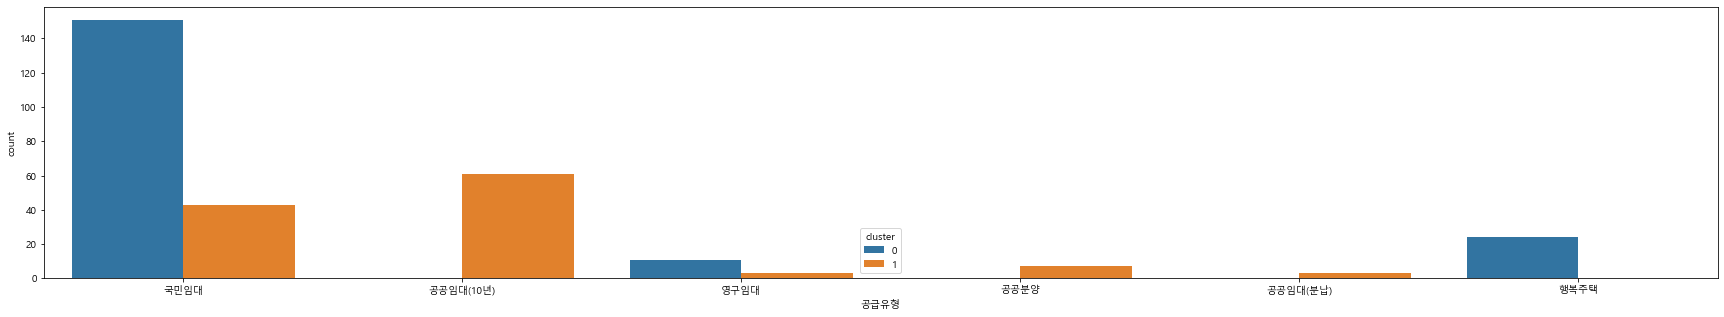

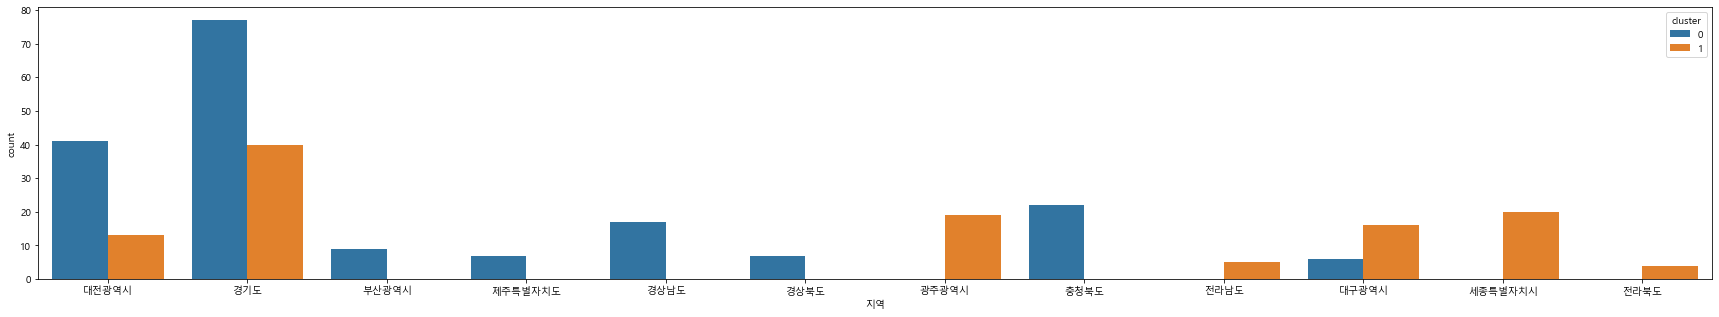

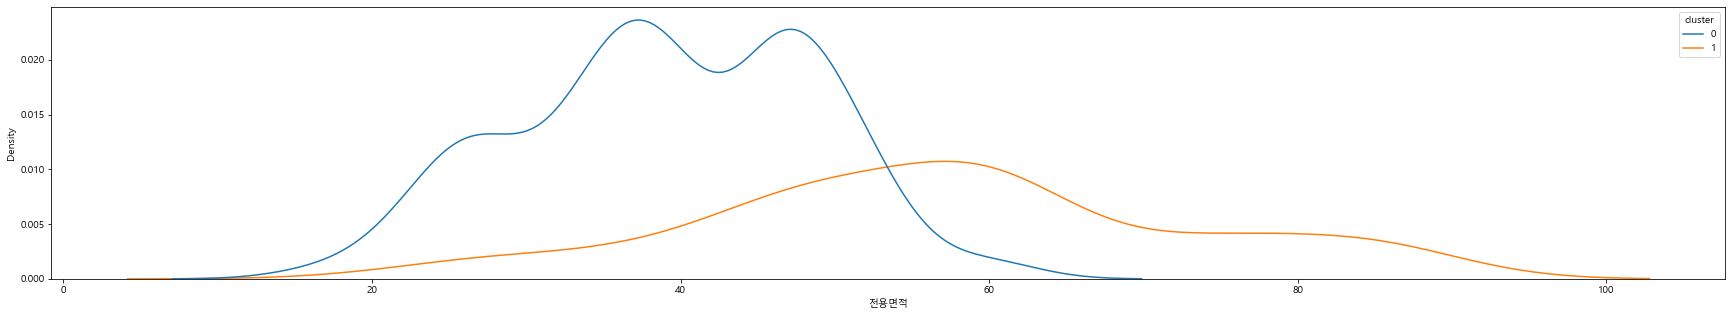

In [25]:
train = train[train['단지내주차면수']>=987].reset_index(drop=True)
test = test[test['단지내주차면수']>=987].reset_index(drop=True)

tmp=train.drop_duplicates(keep='first')
tmp['등록차량수-단지내주차면수'] = tmp.apply(lambda x : x['등록차량수']-x['단지내주차면수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-단지내주차면수']>0 else 0 ,axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-단지내주차면수')

tmp = tmp[(tmp['등록차량수-단지내주차면수']>200)|(tmp['등록차량수-단지내주차면수']<-200)]

tmp.columns

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='전용면적',hue='cluster')

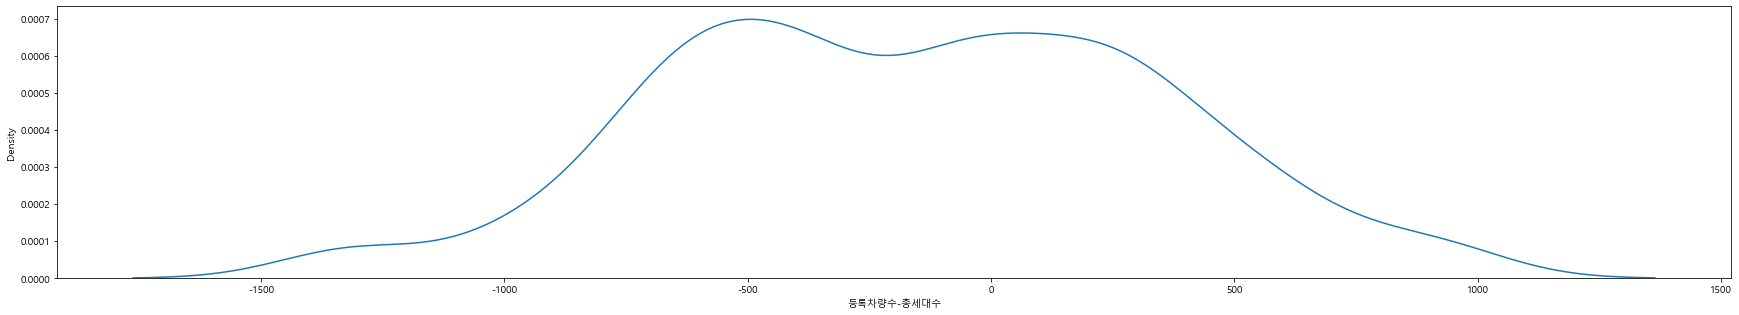

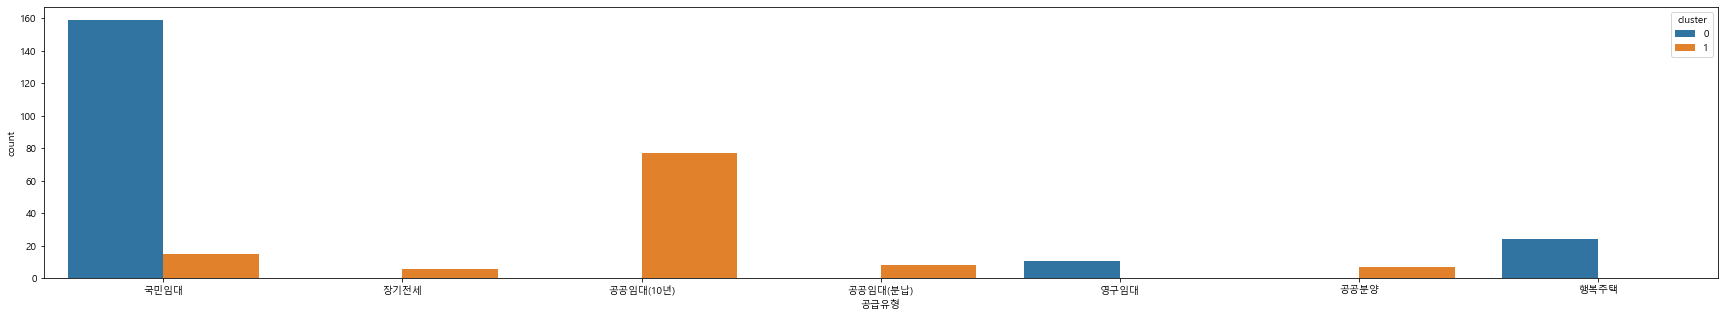

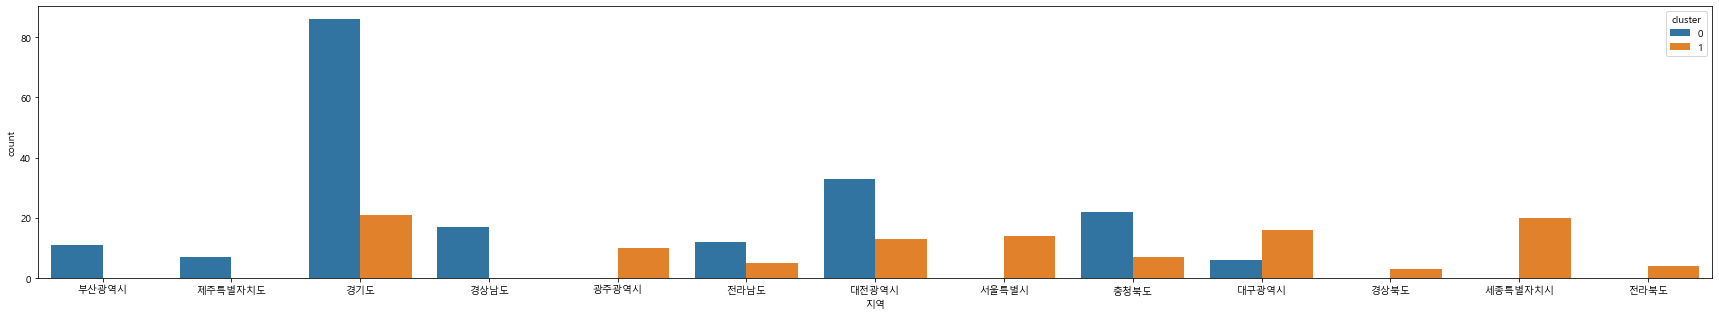

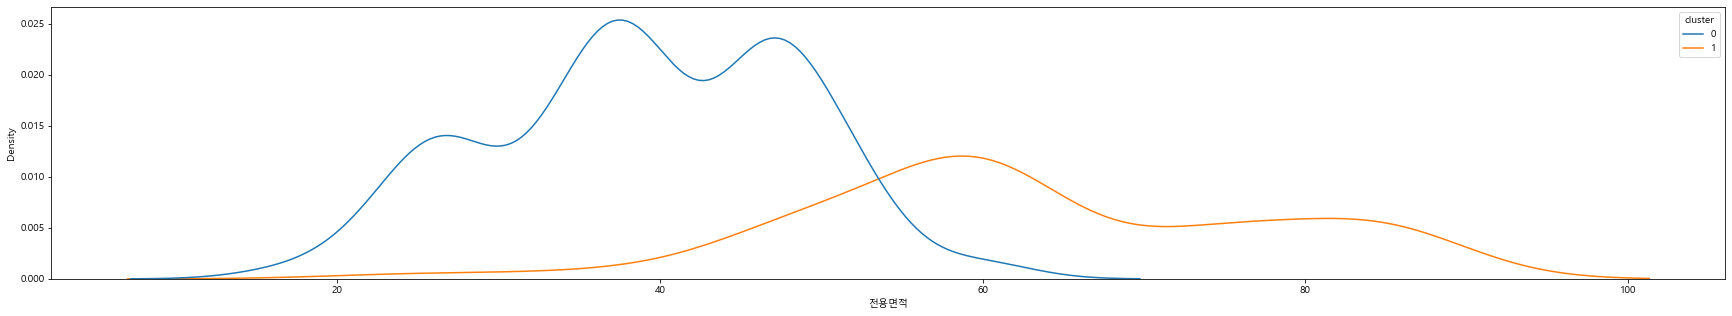

In [26]:
train = train[train['단지내주차면수']>=987].reset_index(drop=True)
test = test[test['단지내주차면수']>=987].reset_index(drop=True)

tmp=train.drop_duplicates(keep='first')
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]

tmp.columns

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='전용면적',hue='cluster')

In [593]:
train['공가수_비율'] =  train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['공가수_비율'] =  test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

In [594]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']

In [595]:
test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [596]:
def areafunc(x):
    if x in ['충청남도','부산광역시','제주특별자치도']:
        return 0
    elif x in ['세종특별자치시','전라남도','전라북도','광주광역시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [597]:
train['지역'] = train['지역'].apply(lambda x : areafunc(x))
test['지역'] = test['지역'].apply(lambda x : areafunc(x))

In [598]:
train = train.join(pd.get_dummies(train['지역'],prefix='area')).iloc[:,:-1]
test = test.join(pd.get_dummies(test['지역'],prefix='area')).iloc[:,:-1]

In [599]:
def func(x):
    if x == '공공임대':
        return 0
    elif x == '행복주택':
        return 1
    else: 
        return 2

In [600]:
train['공급유형_cluster'] = train['공급유형'].apply(lambda x : areafunc(x))
test['공급유형_cluster'] = test['공급유형'].apply(lambda x : areafunc(x))

In [601]:
train = train.join(pd.get_dummies(train['공급유형_cluster'],prefix='cl')).iloc[:,:-1]
train = train.drop('공급유형_cluster',axis=1)

In [602]:
test = test.join(pd.get_dummies(test['공급유형_cluster'],prefix='cl')).iloc[:,:-1]
test = test.drop('공급유형_cluster',axis=1)

In [603]:
def func2(x):
    if x<0.005: 
        return 0
    elif 0.005<x<0.02:
        return 1
    elif 0.02<x<1:
        return 2
    elif x>1:
        return 3

In [604]:
train['sub_cat'] = train['subway_dist'].apply(lambda x : func2(x))
train = train.drop('subway_dist',axis=1)

In [605]:
test['sub_cat'] = test['subway_dist'].apply(lambda x : func2(x))
test = test.drop('subway_dist',axis=1)

In [606]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(train.shape[0]):
    if train.loc[ind,'지역'] in area :
        train.loc[ind,'환승역 수'] = 0

In [607]:
for ind in range(test.shape[0]):
    if test.loc[ind,'지역'] in area :
        test.loc[ind,'환승역 수'] = 0

In [608]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(train.shape[0]):
    if train.loc[ind,'지역'] in area :
        train.loc[ind,'환승역 수'] = 0

for ind in range(test.shape[0]):
    if test.loc[ind,'지역'] in area :
        test.loc[ind,'환승역 수'] = 0

def func3(x,dic):
    for i in dic.keys():
        if len(dic[i]) == len(x):
            if all(dic[i] == x):
                return i

no_shop = train[(train['공급유형']!='임대상가')&(train['공급유형']!='장기전세')]
uniq = np.reshape(no_shop['공급유형'].unique(),(6,1))

dic = dict(enumerate(uniq))
dic[10] = ['국민임대', '영구임대']
dic[11] = ['공공임대(10년)', '공공임대(분납)']
dic[12] = ['공공분양', '공공임대(10년)', '공공임대(분납)']
dic[13] = ['공공임대(10년)', '국민임대']
dic[14] = ['공공임대(50년)', '영구임대']
dic[15] =  ['국민임대', '영구임대', '행복주택']
dic[16] = ['공공임대(10년)', '공공임대(분납)']
dic[17] =  ['국민임대', '행복주택']


no_shop = train[(train['공급유형']!='임대상가')&(train['공급유형']!='장기전세')]
uniq = np.reshape(no_shop['공급유형'].unique(),(6,1))

dic1 = dict()
for i in dic.keys():
    val = train.loc[train['공급유형'].isin(dic[i]),'임대료'].mean()
    dic1[i] = val

# train
no_shop = train[(train['공급유형']!='임대상가')&(train['공급유형']!='장기전세')]
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
train['공급유형1'] = train['cluster'].apply(lambda x: dic1[x])



# test 12 13 14 15 7
no_shop = test[test['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
test['공급유형1'] = test['cluster'].apply(lambda x: dic1[x])



dic2 = dict()
for i in dic.keys():
    val = train.loc[train['공급유형'].isin(dic[i]),'임대보증금'].mean()
    dic2[i] = val

# train
train['공급유형2'] = train['cluster'].apply(lambda x: dic2[x])
train = train.drop(['공급유형','cluster'],axis=1)


# test 12 13 14 15 7
test['공급유형2'] = test['cluster'].apply(lambda x: dic2[x])
test = test.drop(['공급유형','cluster'],axis=1)

In [609]:
train = train.drop(['subway_name', '환승역 수', '총인구수',  '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율'],axis=1)
test = test.drop(['subway_name', '환승역 수', '총인구수', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율'],axis=1)

In [610]:
col = []

for i in ['min','25%','50%','75%','max']:
    for j in ['임대료','임대보증금','전용면적']:
        col.append('apt'+j+i)

col.append('단지코드')

In [611]:
m1 = pd.read_csv("data/train_merged.csv")
m2 = pd.read_csv("data/test_merged.csv")

In [612]:
train = train.drop(['자격유형','임대건물구분','연면적','지역','공가수_비율','전용면적','임대보증금','임대료','단지명','도로명주소','전용면적별세대수'],axis=1).drop_duplicates().reset_index(drop=True)
train = pd.merge(train,m1[col],how='left',on='단지코드')

In [613]:
test = test.drop(['자격유형','임대건물구분','연면적','지역','공가수_비율','전용면적','임대보증금','임대료','단지명','도로명주소','전용면적별세대수'],axis=1).drop_duplicates().reset_index(drop=True)
test = pd.merge(test,m1[col],how='left',on='단지코드')

In [614]:
train['공가수'] = train.apply(lambda x : x['세대당_인구']*x['공가수'],axis=1)
test['공가수'] = test.apply(lambda x : x['세대당_인구']*x['공가수'],axis=1)

In [615]:
train['중년층'] = train.apply(lambda x : x['20~39 인구수']+x['40~69 인구수'],axis=1)

In [616]:
train.corr()['등록차량수']

총세대수           0.3983
공가수           -0.3200
지하철역           0.0969
버스정류장          0.0363
단지내주차면수        0.5726
등록차량수          1.0000
위도            -0.1587
경도             0.0518
세대당_인구         0.1400
세대당_가능주차면수     0.2447
0~19 인구수       0.3665
20~39 인구수      0.3907
40~69 인구수      0.3755
70세이상 인구수      0.0971
area_0        -0.2079
area_1         0.2521
area_2         0.0294
sub_cat       -0.0746
공급유형1          0.4769
공급유형2          0.4337
apt임대료min      0.3322
apt임대보증금min    0.3511
apt전용면적min     0.3065
apt임대료25%      0.3548
apt임대보증금25%    0.3526
apt전용면적25%     0.3262
apt임대료50%      0.3743
apt임대보증금50%    0.2127
apt전용면적50%     0.3340
apt임대료75%      0.3789
apt임대보증금75%    0.1618
apt전용면적75%     0.3586
apt임대료max      0.4141
apt임대보증금max    0.1651
apt전용면적max     0.3852
중년층            0.3973
Name: 등록차량수, dtype: float64

In [617]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as LGB
from catboost import CatBoostRegressor

# Fitting
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as LGB
from catboost import CatBoostRegressor

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [618]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    print(best_tst_idx)
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [619]:
X = train.drop(columns=['단지코드','등록차량수','세대당_인구'],axis=1) 
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
y = train['등록차량수']

models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          SVR(),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021),
          XGBRegressor(random_state=2021)]

best_model1, best_tst_pred1, best_error1 = fit_models(X, y, models, cv=True)
print(best_model1, best_error1)

model:LinearRegression
MAE:261.4667127541153
model:PLSRegression
MAE:215.15746062018175
model:Ridge
MAE:223.80688039841434
model:Lasso
MAE:231.35571220384108
model:ElasticNet
MAE:208.61741450664127
model:SVR
MAE:300.6676958408317
model:<catboost.core.CatBoostRegressor object at 0x00000262A2D303A0>
MAE:217.68496317663548
model:RandomForestRegressor
MAE:235.5603833333333
model:GradientBoostingRegressor
MAE:227.31601708624459
model:XGBRegressor
MAE:246.63485113234748
[2, 4, 6, 8, 13, 22, 30, 32, 35, 46, 47, 58, 61, 64, 67, 76, 77, 78, 80, 92, 95, 3, 20, 23, 28, 31, 34, 37, 43, 45, 55, 56, 59, 60, 69, 74, 75, 82, 83, 97, 99, 101, 9, 11, 15, 17, 27, 39, 40, 42, 51, 53, 65, 68, 72, 73, 79, 84, 87, 88, 96, 98, 103, 5, 10, 14, 16, 18, 19, 25, 36, 38, 41, 48, 49, 50, 52, 54, 63, 71, 81, 89, 100, 102, 0, 1, 7, 12, 21, 24, 26, 29, 33, 44, 57, 62, 66, 70, 85, 86, 90, 91, 93, 94]
ElasticNet(random_state=2021) 208.61741450664127


In [620]:
X = train.drop(columns=['단지코드','등록차량수','세대당_인구'],axis=1) 
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
y = train['등록차량수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)

model_2= ElasticNet(random_state=2021).fit(X_train, y_train)
model2_pred = model_2.predict(X_test)

print(mean_absolute_error(model2_pred, y_test))

238.5239794904358


In [ ]:
plt.figure(figsize=(12,16))
sns.barplot(y = X_train.columns[np.argsort(model2.feature_importances_)], x = list(model2.feature_importances_[np.argsort(model2.feature_importances_)]))

In [453]:
prediction2 = pd.DataFrame(columns=['단지코드','등록차량수','y_pred'])
prediction2['단지코드'] = train.loc[X_test.index.values,'단지코드']
prediction2['등록차량수'] = train.loc[X_test.index.values,'등록차량수']
prediction2['y_pred'] = model2_pred
prediction2['mae'] = prediction2.apply(lambda x : x['y_pred']-x['등록차량수'], axis=1)
prediction2['score'] = prediction2['mae'].apply(lambda x : 1 if abs(x)<=150 else 0) #0 나쁜 성적
prediction2['세대당_인구'] = train.loc[X_test.index.values,'세대당_인구']

In [454]:
val = prediction2[(prediction2['score']==0)]['단지코드'].values
tmp = train.loc[train['단지코드'].isin(val),:]
tmp['mae'] = prediction2[(prediction2['score']==0)]['mae'].values
tmp['up/down'] = prediction2.apply(lambda x : 1 if x['mae']>0 else 0,axis=1)

In [455]:
prediction2

,단지코드,등록차량수,y_pred,mae,score,세대당_인구
92,C2595,"1,359.0000","1,495.2856",136.2856,1,2.2367
2,C1032,316.0000,938.0369,622.0369,0,2.5900
46,C1406,"1,350.0000","1,414.2087",64.2087,1,2.4200
4,C1672,873.0000,"1,410.1200",537.1200,0,2.4633
80,C2612,"1,832.0000","1,141.8269",-690.1731,0,2.7300
8,C1885,616.0000,604.4616,-11.5384,1,2.3000
32,C1527,"1,150.0000",900.8310,-249.1690,0,2.2500
22,C2032,"1,162.0000","1,016.4889",-145.5111,1,2.7700
13,C2000,795.0000,"1,076.5528",281.5528,0,2.4400
61,C1969,886.0000,952.3676,66.3676,1,2.2700


In [456]:
tmp

,단지코드,총세대수,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,위도,경도,세대당_인구,세대당_가능주차면수,0~19 인구수,20~39 인구수,40~69 인구수,70세이상 인구수,area_0,area_1,area_2,area_3,sub_cat,공급유형1,공급유형2,apt임대료min,apt임대보증금min,apt전용면적min,apt임대료25%,apt임대보증금25%,apt전용면적25%,apt임대료50%,apt임대보증금50%,apt전용면적50%,apt임대료75%,apt임대보증금75%,apt전용면적75%,apt임대료max,apt임대보증금max,apt전용면적max,중년층,mae,up/down
2,C1032,946,15.5400,1.0000,2.0000,986.0000,316.0000,127.4467,36.3148,2.5900,1.0423,220.0550,205.4712,432.3601,88.1136,0,0,0,0,1,"193,907.2193","28,885,759.3583","118,580.0000","16,852,000.0000",39.6500,"159,172.5000","24,031,750.0000",47.8125,"187,260.0000","28,714,000.0000",51.8800,"220,027.5000","33,395,500.0000",57.9725,"230,950.0000","34,956,000.0000",59.9900,637.8313,622.0369,1
3,C1068,806,24.4200,0.0000,2.0000,804.0000,510.0000,126.6118,36.3478,2.2200,0.9975,171.9303,202.8964,362.9205,68.2528,0,1,0,0,2,"193,907.2193","28,885,759.3583","106,090.0000","11,234,000.0000",36.6500,"110,775.0000","12,170,750.0000",38.1225,"137,320.0000","16,853,500.0000",44.2050,"149,810.0000","18,726,000.0000",46.9500,"168,520.0000","24,343,000.0000",51.9300,565.8169,537.1200,1
4,C1672,1350,36.9500,0.0000,1.0000,"1,043.0000",873.0000,129.0346,35.2039,2.4633,0.7726,204.7561,344.9873,660.3323,139.9243,0,1,0,0,1,"193,907.2193","28,885,759.3583","213,320.0000","17,417,000.0000",51.8800,"221,572.5000","18,067,250.0000",53.8175,"229,825.0000","18,717,500.0000",55.7550,"238,077.5000","19,367,750.0000",57.6925,"246,330.0000","20,018,000.0000",59.6300,"1,005.3196",-690.1731,1
6,C1005,1144,45.1200,0.0000,8.0000,950.0000,376.0000,127.1193,36.8210,2.8200,0.8304,314.8525,333.4762,457.0977,38.5735,0,1,0,0,2,"193,907.2193","28,885,759.3583","208,470.0000","16,205,000.0000",51.4900,"209,685.0000","16,276,500.0000",51.7200,"210,900.0000","16,348,000.0000",51.9500,"228,835.0000","17,559,000.0000",55.7950,"246,770.0000","18,770,000.0000",59.6400,790.5739,-249.1690,1
13,C2000,1300,51.2400,0.0000,2.0000,"1,082.0000",795.0000,129.0259,35.3019,2.4400,0.8323,282.1496,347.1385,573.1916,97.5204,0,0,1,0,1,"193,907.2193","28,885,759.3583","90,110.0000","10,813,000.0000",36.6500,"102,125.0000","12,255,000.0000",38.0650,"169,420.0000","19,225,000.0000",46.9000,"169,420.0000","19,225,000.0000",46.9000,"219,880.0000","26,435,000.0000",59.8800,920.3300,281.5528,1
23,C2089,962,62.9100,0.0000,1.0000,873.0000,572.0000,128.7403,35.3044,2.3300,0.9075,214.7304,238.4473,439.5042,69.3181,0,0,1,0,2,"193,907.2193","28,885,759.3583","123,870.0000","13,625,000.0000",39.7200,"123,870.0000","13,625,000.0000",39.7225,"130,060.0000","16,722,000.0000",43.3150,"145,535.0000","22,606,750.0000",50.6725,"148,630.0000","23,536,000.0000",51.9300,677.9515,229.4639,1
28,C1693,853,46.8000,0.0000,6.0000,862.0000,"1,087.0000",127.3852,36.4392,2.3400,1.0106,167.5585,254.6250,371.0926,59.7238,0,0,0,0,2,"193,907.2193","28,885,759.3583","156,030.0000","24,969,000.0000",46.9300,"179,452.5000","29,649,750.0000",50.4325,"187,260.0000","31,210,000.0000",51.6750,"199,745.0000","32,771,000.0000",53.8025,"237,200.0000","37,454,000.0000",59.9600,625.7177,-274.4879,0
30,C1579,1005,30.6000,0.0000,2.0000,882.0000,"1,158.0000",127.1650,37.4115,2.5500,0.8776,204.5103,270.9361,452.3717,77.1819,0,0,0,0,2,"193,907.2193","28,885,759.3583","162,250.0000","19,572,000.0000",36.9800,"162,250.0000","19,572,000.0000",36.9800,"257,660.0000","34,810,000.0000",46.9500,"291,110.0000","44,348,000.0000",51.9900,"346,850.0000","56,985,000.0000",59.9300,723.3078,-211.4188,0
32,C1527,996,51.7500,0.0000,4.0000,834.0000,"1,150.0000",128.6964,36.5626,2.2500,0.8373,208.6354,233.3825,460.6477,93.3345,0,0,0,0,2,"193,907.2193","28,885,759.3583","126,680.0000","15,252,000.0000",46.6100,"126,680.0000","15,252,000.0000",46.6100,"154,270.0000","19,204,000.0000",51.8600,"180,630.0000","22,579,000.0000",59.2900,"180,630.0000","22,579,000.0000",59.5700,694.0302,821.0267,0
34,C1236,1124,75.4000,0.0000,2.0000,"1,129.0000",657.0000,127.0859,37.7939,2.6000,1.0044,260.0656,239.4003,515.4917,109.0424,0,0,0,0,2,"193,907.2193","28,885

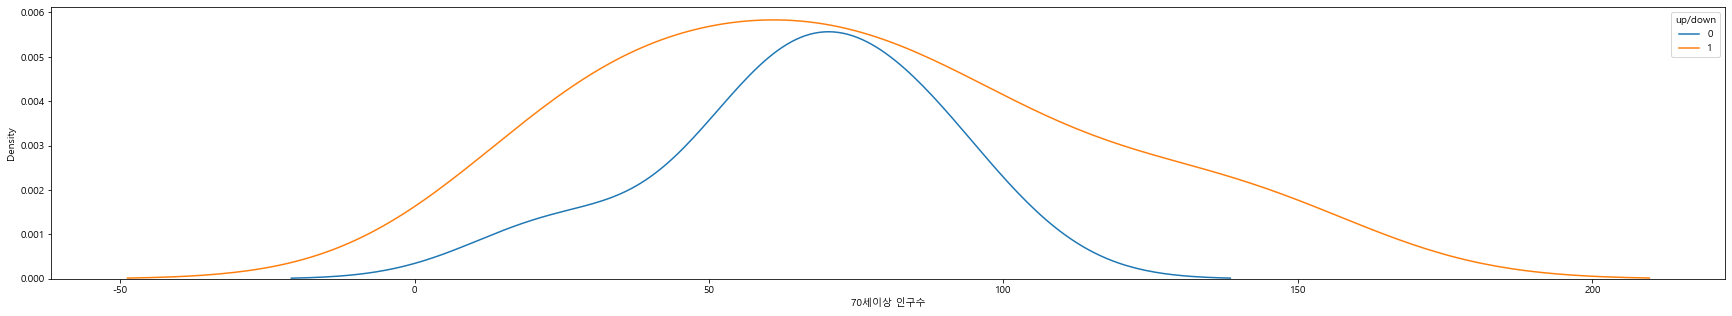

In [443]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='70세이상 인구수',hue='up/down')

In [440]:
tmp.columns

Index(['단지코드', '총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '위도', '경도',
       '세대당_인구', '세대당_가능주차면수', '0~19 인구수', '20~39 인구수', '40~69 인구수',
       '70세이상 인구수', 'area_0', 'area_1', 'area_2', 'area_3', 'sub_cat', '공급유형1',
       '공급유형2', 'apt임대료min', 'apt임대보증금min', 'apt전용면적min', 'apt임대료25%',
       'apt임대보증금25%', 'apt전용면적25%', 'apt임대료50%', 'apt임대보증금50%', 'apt전용면적50%',
       'apt임대료75%', 'apt임대보증금75%', 'apt전용면적75%', 'apt임대료max', 'apt임대보증금max',
       'apt전용면적max', 'mae', 'up/down'],
      dtype='object')

In [379]:
tmp

,단지코드,총세대수,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,위도,경도,세대당_인구,세대당_가능주차면수,0~19 인구수,20~39 인구수,40~69 인구수,70세이상 인구수,area_0,area_1,area_2,area_3,sub_cat,공급유형1,공급유형2,apt임대료min,apt임대보증금min,apt전용면적min,apt임대료25%,apt임대보증금25%,apt전용면적25%,apt임대료50%,apt임대보증금50%,apt전용면적50%,apt임대료75%,apt임대보증금75%,apt전용면적75%,apt임대료max,apt임대보증금max,apt전용면적max,mae,up/down
2,C1032,946,15.5400,1.0000,2.0000,986.0000,316.0000,127.4467,36.3148,2.5900,1.0423,220.0550,205.4712,432.3601,88.1136,0,0,0,0,1,"193,907.2193","28,885,759.3583","118,580.0000","16,852,000.0000",39.6500,"159,172.5000","24,031,750.0000",47.8125,"187,260.0000","28,714,000.0000",51.8800,"220,027.5000","33,395,500.0000",57.9725,"230,950.0000","34,956,000.0000",59.9900,608.2186,1
4,C1672,1350,36.9500,0.0000,1.0000,"1,043.0000",873.0000,129.0346,35.2039,2.4633,0.7726,204.7561,344.9873,660.3323,139.9243,0,1,0,0,1,"193,907.2193","28,885,759.3583","213,320.0000","17,417,000.0000",51.8800,"221,572.5000","18,067,250.0000",53.8175,"229,825.0000","18,717,500.0000",55.7550,"238,077.5000","19,367,750.0000",57.6925,"246,330.0000","20,018,000.0000",59.6300,207.6595,1
6,C1005,1144,45.1200,0.0000,8.0000,950.0000,376.0000,127.1193,36.8210,2.8200,0.8304,314.8525,333.4762,457.0977,38.5735,0,1,0,0,2,"193,907.2193","28,885,759.3583","208,470.0000","16,205,000.0000",51.4900,"209,685.0000","16,276,500.0000",51.7200,"210,900.0000","16,348,000.0000",51.9500,"228,835.0000","17,559,000.0000",55.7950,"246,770.0000","18,770,000.0000",59.6400,-392.7575,1
22,C2032,944,63.7100,0.0000,1.0000,958.0000,"1,162.0000",128.8055,35.1734,2.7700,1.0148,280.7499,239.4353,388.9171,34.8977,0,0,1,0,2,"193,907.2193","28,885,759.3583","149,810.0000","24,969,000.0000",51.7800,"177,897.5000","29,649,750.0000",57.8325,"187,260.0000","31,210,000.0000",59.8700,"187,260.0000","31,210,000.0000",59.9200,"187,260.0000","31,210,000.0000",59.9500,-325.3582,0
28,C1693,853,46.8000,0.0000,6.0000,862.0000,"1,087.0000",127.3852,36.4392,2.3400,1.0106,167.5585,254.6250,371.0926,59.7238,0,0,0,0,2,"193,907.2193","28,885,759.3583","156,030.0000","24,969,000.0000",46.9300,"179,452.5000","29,649,750.0000",50.4325,"187,260.0000","31,210,000.0000",51.6750,"199,745.0000","32,771,000.0000",53.8025,"237,200.0000","37,454,000.0000",59.9600,-346.6447,0
30,C1579,1005,30.6000,0.0000,2.0000,882.0000,"1,158.0000",127.1650,37.4115,2.5500,0.8776,204.5103,270.9361,452.3717,77.1819,0,0,0,0,2,"193,907.2193","28,885,759.3583","162,250.0000","19,572,000.0000",36.9800,"162,250.0000","19,572,000.0000",36.9800,"257,660.0000","34,810,000.0000",46.9500,"291,110.0000","44,348,000.0000",51.9900,"346,850.0000","56,985,000.0000",59.9300,215.0569,0
32,C1527,996,51.7500,0.0000,4.0000,834.0000,"1,150.0000",128.6964,36.5626,2.2500,0.8373,208.6354,233.3825,460.6477,93.3345,0,0,0,0,2,"193,907.2193","28,885,759.3583","126,680.0000","15,252,000.0000",46.6100,"126,680.0000","15,252,000.0000",46.6100,"154,270.0000","19,204,000.0000",51.8600,"180,630.0000","22,579,000.0000",59.2900,"180,630.0000","22,579,000.0000",59.5700,-238.0929,0
34,C1236,1124,75.4000,0.0000,2.0000,"1,129.0000",657.0000,127.0859,37.7939,2.6000,1.0044,260.0656,239.4003,515.4917,109.0424,0,0,0,0,2,"193,907.2193","28,885,759.3583","111,470.0000","16,225,000.0000",39.7200,"140,277.5000","20,686,000.0000",44.9925,"151,110.0000","22,173,000.0000",46.9000,"167,230.0000","24,402,000.0000",49.7000,"167,230.0000","24,402,000.0000",49.7000,-171.7376,1
37,C2070,898,16.6800,0.0000,3.0000,909.0000,735.0000,127.1576,37.2840,2.7800,1.0122,236.5874,192.8267,391.0361,77.5499,0,0,0,0,1,"193,907.2193","28,885,759.3583","172,660.0000","18,175,000.0000",39.4800,"206,410.0000","21,420,000.0000",46.9600,"206,410.0000","21,420,000.0000",46.9600,"267,420.0000","24,017,000.0000",51.8600,"306,370.0000","27,263,000.0000",59.5700,-259.3506,1
58,C1740,783,73.6600,0.0000,6.0000,978.0000,979.0000,128.1891,36.1203,2.5400,1.2490,234.0846,241.8586,286.8098,20.2470,0,0,0,0,2,"526,990.2439","50,020,756.0976","416,000.0000","31,000,000.0000",59.9500,"416,000.0000","31,000,000.0000",5